<a href="https://colab.research.google.com/github/codewithhari98/Machine_Learning/blob/main/SVM_and_SMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [241]:
#references:
#https://github.com/ajdillhoff/CSE6363/tree/main/svm
#"Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines" by John C. Platt
#https://github.com/adeveloperdiary/blog/blob/master/SVM/NonLinearSVM_DualProblem.py
#http://www.adeveloperdiary.com/data-science/machine-learning/support-vector-machines-for-beginners-training-algorithms/
#https://github.com/Reznic/SVM-Project/blob/main/maman13_SVM.ipynb

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from mlxtend.plotting.decision_regions import plot_decision_regions
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import svm


def linear_kernel(x1, x2):
    return x1.T @ x2

def poly_kernel(x1,x2,d=3):
  return (1.0 + x1.dot(x2.T)) ** d
class svm_userdef():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=10,d=3):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        self.d=d
        if self._kernel == 'linear':
            self._k = linear_kernel
        elif self._kernel=='poly':
          self._k=poly_kernel
        elif self._kernel==np.dot:
          self._k=np.dot
        
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        self.ones = np.ones(self._data.shape[0])
        if self._kernel == 'linear':
            self._weights = np.random.rand(self._data.shape[1])
        elif self._kernel=='poly':
            pass
            #self._weights = np.random.rand(self._data.shape[1])

    def _decision_function(self, X):
        if (self._k==np.dot):
          return (self._alphas * self._targets).dot(self._k(self._data, X.T)) - self._b

        return (self._alphas * self._targets).dot(self._k(self._data, X)) - self._b

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            u += np.sign(self._decision_function(x))
        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
        x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
          score[score < 0] = -1
          score[score >= 0] = 1

          return score
        else:
           return -1 if score < 0 else 1
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.mean(y == y_hat)
    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0
        
        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)
        #print(k11)
        eta = k11 + k22 - 2 * k12
        #Tested the negative eta initially
        #eta=-2

        if eta >= 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        elif eta<0:
          L1=alpha1+(s*(alpha2-L))
          H1=alpha1+(s*(alpha2-H))
          F1=(y1*(e1+self._b))-(alpha1*k11)-(s*alpha2*k12)
          F2=(y2*(e2+self._b))-(s*(alpha1*k12))-(alpha2*k22)
          Lobj=(L1*F1)+(L*F2)+(0.5*(L1**2)*k11)+(0.5*(L**2)*k22)+(s*L*L1*k12)
          Hobj=(H1*F1)+(H*F2)+(0.5*(H1**2)*k11)+(0.5*(H**2)*k22)+(s*H*H1*k12)
          if(Lobj<(Hobj-1e-3)):
            a2=L
          elif(Lobj>(Hobj+1e-3)):
            a2=H
          else:
            a2=alpha2
        else:
            print(f"[DEBUG] smo_step: eta = {eta}")
            
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear
        if self._kernel == 'linear':
            self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1
    def evaluate_model(self, data, labels):
        predicted_labels = self.predict_score(data)
        # count misclassified labels
        error_count = sum(abs(predicted_labels - labels) / 2)
        error_ratio = error_count / len(labels)
        return error_ratio
    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                if e2 > 0:
                    min_error = 10
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -10
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i in range(self._data.shape[0]):
                    if i == i2:
                        continue
                    if self.smo_step(i, i2):
                        return 1
                
        return 0
 
    def fit(self, data, targets):
          self._data = data
          self._targets = targets
          
          self._init_params()
          
          n_changed = 0
          examine_all = True
          n_iter = 0
          
          while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
              n_changed = 0
              n_iter += 1
              
              if examine_all is True:
                  # loop over all training examples
                  for i in range(data.shape[0]):
                      n_changed += self.examine(i)
              else:
                  # loop over examples where alpha is not 0 & not C
                  f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                  for i, v in enumerate(f_idxs):
                      n_changed += self.examine(v)
              
              if examine_all is True:
                  examine_all = False
              elif n_changed == 0:
                  examine_all = True
        
    def plot_decision_boundary(self):
          plt.scatter(self._data[:, 0], self._data[:, 1], c=self._targets, s=10, cmap=plt.cm.Paired, alpha=.5)
          ax = plt.gca()
          xlim = ax.get_xlim()
          ylim = ax.get_ylim()

          # create grid to evaluate model
          xx = np.linspace(xlim[0], xlim[1], 30)
          yy = np.linspace(ylim[0], ylim[1], 30)
          YY, XX = np.meshgrid(yy, xx)
          xy = np.vstack([XX.ravel(), YY.ravel()]).T
          Z = self._decision_function(xy).reshape(XX.shape)

          # plot decision boundary and margins
          ax.contour(XX, YY, Z, colors=['b', 'g', 'r'], levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'], linewidths=[2.0, 2.0, 2.0])

          plt.show()


weights=[-1.60377651 10.50236707]
b=0.6925348552613986


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


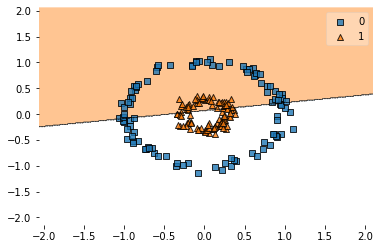

In [242]:
def linear_svm_test():
  X, y = make_circles(n_samples=2000, factor=0.3, noise=0.05, random_state=0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,stratify=y, random_state=0)

  model = svm_userdef(c=5.0)
  model.fit(X_train,y_train)

  print(f"weights={model._weights}")
  print(f"b={model._b}")

  fig = plt.figure()
  ax = plot_decision_regions(X_test,y_test.astype(np.int32), model)
  fig.add_subplot(ax)
  plt.show()

linear_svm_test()

coef_=[[ 0.11332551 -0.11088427]]
intercept=[-6.42011386e-05]


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


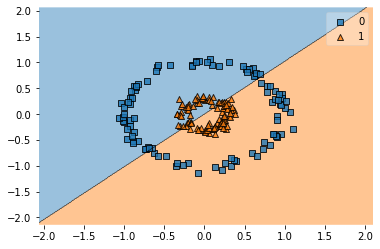

In [243]:
from sklearn.svm import LinearSVC
def linear_svm_test_inbuilt():
  X, y = make_circles(n_samples=2000, factor=0.3, noise=0.05, random_state=0)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,stratify=y, random_state=0)
  sk_model = LinearSVC()
  sk_model.fit(X_test,y_test.astype(np.int32))

  print(f"coef_={sk_model.coef_}")
  print(f"intercept={sk_model.intercept_}")

  fig = plt.figure()
  ax = plot_decision_regions(X_test,y_test.astype(np.int32), sk_model)
  fig.add_subplot(ax)
  plt.show()

linear_svm_test_inbuilt()

test score: 1.0


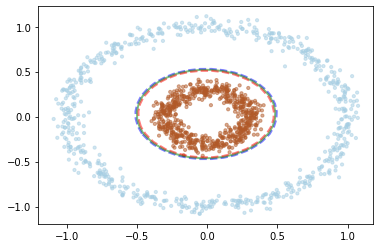

In [244]:
def poly_svm_user_test():
  X, y = make_circles(n_samples=1500, factor=0.3, noise=0.05, random_state=0)
  y[y == 0] = -1
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,stratify=y)

  svm_poly_model = svm_userdef(kernel='poly',c=1.0)
  svm_poly_model.fit(X_train, y_train)
  print("test score:", svm_poly_model.score(X_test, y_test))
  svm_poly_model.plot_decision_boundary()

poly_svm_user_test()

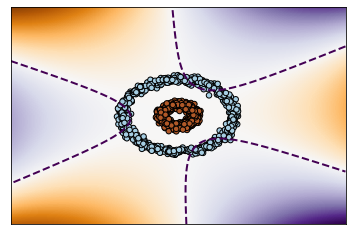

In [245]:
from sklearn import svm
xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
np.random.seed(0)
X, y = make_circles(n_samples=1500, factor=0.3, noise=0.05, random_state=0)
y[y == 0] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,stratify=y)

# fit the model
clf = svm.SVC(kernel='poly')
clf.fit(X, y)

# plot the decision function for each datapoint on the grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2, linestyles="dashed")
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired, edgecolors="k")
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])
plt.show()

In [246]:
iris = load_iris()
x,y=iris.data,iris.target
class OneVsAllSVM(svm_userdef):
  def __init__(self, class_label, kernel=np.dot, c=1,accuracy=0.001):
        super().__init__(kernel=np.dot, c=1.0)
        self.unique_label = class_label
  def get_binary_labels(self, labels):
        return [1 if label == self.unique_label else -1 
                for label in labels]
  def fit(self, X, Y):
        binary_labels = self.get_binary_labels(Y)
        super().fit(X, binary_labels)
  def evaluate_model(self, data, labels):
        binary_labels = self.get_binary_labels(labels)
        return super().evaluate_model(data, binary_labels)

class MulticlassSVM:
    def __init__(self, class_labels, c=1, kernel=np.dot, accuracy=0.001):
        self.class_labels = class_labels

        # Support option of giving same hyperparam for all SVM classifiers
        if type(c) is not list:
            c = [c] * len(class_labels)
        if type(kernel) is not list:
            kernel = [kernel] * len(class_labels)
        if type(accuracy) is not list:
            accuracy = [accuracy] * len(class_labels)
        # Init One-VS-All SVM model for each class
        self.classifiers = [OneVsAllSVM(label, kernel[i], c[i], accuracy[i]) 
                            for i, label in enumerate(class_labels)]

    def predict(self, x):
        predictions = [classifier._decision_function(x) for classifier in self.classifiers]
        max_classifiers = np.argmax(np.array(predictions), axis=0)
        return [self.classifiers[i].unique_label for i in max_classifiers]
        
    def fit(self, X, Y):
        for classifier in self.classifiers:
            classifier.fit(X, Y)

    def predicted_val(self, data, labels):
        predicted_labels = self.predict(data)
        print(predicted_labels)
        for i in range(len(labels)):
              print(str(i)+"- test label: ",iris.target_names[labels[i]])
              print(" predicted label: ", iris.target_names[predicted_labels[i]])

In [250]:
iris = load_iris()
x,y=iris.data,iris.target
features=iris.feature_names
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.9,test_size=0.1,stratify=y, random_state=0)
classes = np.unique(iris["target"])

# Get the class labels in the Iris dataset
classes = np.unique(iris["target"])

# Grid-search for the hyper parameter C.
C=1
print(f"C={C}")
iris_model = MulticlassSVM(class_labels=classes, c=C)
iris_model.fit(x_train, y_train)
iris_model.predicted_val(x_test, y_test)



C=1
[1, 0, 2, 0, 2, 0, 0, 1, 2, 2, 0, 2, 2, 2, 1]
0- test label:  versicolor
 predicted label:  versicolor
1- test label:  setosa
 predicted label:  setosa
2- test label:  versicolor
 predicted label:  virginica
3- test label:  setosa
 predicted label:  setosa
4- test label:  virginica
 predicted label:  virginica
5- test label:  setosa
 predicted label:  setosa
6- test label:  setosa
 predicted label:  setosa
7- test label:  versicolor
 predicted label:  versicolor
8- test label:  versicolor
 predicted label:  virginica
9- test label:  virginica
 predicted label:  virginica
10- test label:  setosa
 predicted label:  setosa
11- test label:  virginica
 predicted label:  virginica
12- test label:  virginica
 predicted label:  virginica
13- test label:  virginica
 predicted label:  virginica
14- test label:  versicolor
 predicted label:  versicolor


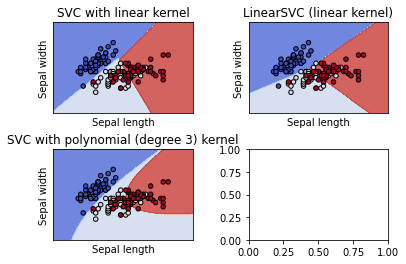

In [248]:
def make_meshgrid(x, y, h=0.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
def iris_inbuiltsvm_test():
  iris = load_iris()
  X = iris.data[:, :2]
  y = iris.target
  C = 1.0  # SVM regularization parameter

  models = (
      svm.SVC(kernel="linear", C=C),
      svm.LinearSVC(C=C, max_iter=10000),
      svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
  )
  models = (clf.fit(X, y) for clf in models)

  # title for the plots
  titles = (
      "SVC with linear kernel",
      "LinearSVC (linear kernel)",
      "SVC with polynomial (degree 3) kernel",
  )
  fig, sub = plt.subplots(2, 2)
  plt.subplots_adjust(wspace=0.4, hspace=0.4)
  X0, X1 = X[:, 0], X[:, 1]
  xx, yy = make_meshgrid(X0, X1)

  for clf, title, ax in zip(models, titles, sub.flatten()):
      plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
      ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
      ax.set_xlim(xx.min(), xx.max())
      ax.set_ylim(yy.min(), yy.max())
      ax.set_xlabel("Sepal length")
      ax.set_ylabel("Sepal width")
      ax.set_xticks(())
      ax.set_yticks(())
      ax.set_title(title)

  plt.show()
iris_inbuiltsvm_test()